# 類似画像の検出をしよう

## 簡単な形状認識 - Average Hash

最初に、画像の形状を手軽に検出する方法を紹介する。Average Hashを利用すると、画像の類似地を計算することができる。  
Average Hashは、画像を比較可能なハッシュ値で表す。ハッシュ関数MD5やSHA256などを使うと、様々なデータの値を要約したハッシュ値を得ることができる。そして、これらのハッシュ値は同一データを検出するのに非常に役立つ。  
しかし、大きな意味で画像が同一かどうかを検出するのに、MD5やSHA256などのハッシュ関数を利用することはできない。完全に同一のバイナリを探すならば、こちらのハッシュ関数を利用することができるが、画像データは画像解像度をリサイズしたり、色調補正したり、JPEG/PNGと圧縮形式を変更したりと、様々な変更が加えられ、完全に同一ではないことも多い。  
写真を多少明るく補正してあったとしても、同一の画像として検索できた方が便利な場面が多くあり、その時に役立つのが、類似度の計算に使えるAverage Hashである。  
具体的な方法だが、以下のような手順で行う。  
1. 画像のサイズを8*8に縮小
2. 色をグレイスケールに変換
3. 画像の各ピクセルの平均値を計算
4. 各ピクセルの濃淡が平均より大きければ1、平均以下なら0とする  
以上のような簡単な手順で、画像の形状を表す64ビットのハッシュ値が得られる。この方法であれば、64ビットを比較するだけなので、高速に類似画像を検索することができる。

In [3]:
from PIL import Image
import numpy as np

In [7]:
# 画像データをAverage Hashに変換
def average_hash(fname, size = 16):
    img = Image.open(fname)
    img = img.convert('L') # グレースケールに変換
    img = img.resize((size, size), Image.ANTIALIAS) # アンチエイリアス処理を施した後リサイズ
    pixel_data = img.getdata() # ピクセルデータを得る
    pixels = np.array(pixel_data) # Numpyの配列に変換
    pixels = pixels.reshape((size, size)) # 二次元の配列に変換
    avg = pixels.mean() # 算術平均を計算
    diff = 1 * (pixels > avg) # 平均より大きければ値を1、平均以下で0に変換
    return diff

In [8]:
# 二進数とみなしてハッシュ値に変換
def np2hash(n):
    bhash = []
    for nl in ahash.tolist():
        sl = [str(i) for i in nl]
        s2 ="".join(sl)
        i = int(s2, 2) # 二進数を整数に
        bhash.append("%04x" % i)
    return "".join(bhash)

In [9]:
# Average Hashを表示
ahash = average_hash('tower.jpg')
print(ahash)
print(np2hash(ahash))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
 [1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0]
 [1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0]
 [1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]]
000001000180018003c003c003c087e07ff05ff07ff2cffa9ffe3ffe3ffe1fff


### たくさんの画像から類似する画像を検索する

Average Hashがわかったところで、たくさんの画像の中からこの画像に類似するものを選び出すプログラムを作っていく。ここでは、サンプル画像として、カリフォルニア工科大学が機械学習のために配布している様々な画像データセット「Computational Vision at CALTECH」を利用してみる。

In [27]:
from PIL import Image
import numpy as np
import os, re

In [28]:
# ファイルパスの指定
search_dir = "./image/101_ObjectCategories"
cache_dir = "./image/cache_avhash"

In [29]:
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [30]:
# 画像データをAverage hashに変換
def average_hash(fname, size=16):
    fname2 = fname[len(search_dir):]
    # 画像をキャッシュしておく
    cache_file = cache_dir + "/" + fname2.replace('/', '_') + ".csv"
    if not os.path.exists(cache_file): # ハッシュを作成
        img = Image.open(fname)
        img = img.convert('L').resize((size, size), Image.ANTIALIAS)
        pixels = np.array(img.getdata()).reshape((size, size))
        avg = pixels.mean()
        px = 1 * (pixels > avg)
        np.savetxt(cache_file, px, fmt="%.0f", delimiter=",")
    else: # すでにキャッシュがあればファイルから読み込み
        px = np.loadtxt(cache_file, delimiter=",")
    return px

In [31]:
# 簡単にハミング距離を求める
def hamming_dist(a, b):
    aa = a.reshape(1, -1) # 1次元の配列に変換
    ab = b.reshape(1, -1)
    dist = (aa != ab).sum()
    return dist

In [32]:
# 全てのディレクトリを列挙
def enum_all_files(path):
    for root, dirs, files in os.walk(path):
        for f in files:
            fname = os.path.join(root, f)
            if re.search(r'\.(jpg|jpeg|png)$', fname):
                yield fname

In [33]:
# 画像を検索
def find_image(fname, rate):
    src = average_has(fname)
    for fname in enum_all_files(search_dir):
        dst = average_hash(fname)
        diff_r = hamming_dist(src, dst)/256
        # print("[check] ", fname)
        if diff_r < rate:
            yield (diff_r, fname)

In [34]:
# 検索
srcfile = search_dir + "/chair/image_0016.jpg"
html = ""
sim = list(find_image(srcfile, 0.25))
sim = sorted(sim, key=lambda x:x[0])
for r, f in sim:
    print(r, ">", f)
    s = '<div style="float:left;"><h3>[差異:' + str(r) + '-' + \
        os.path.basename(f) + ']</h3>' + \
    '<p><a href="' + f + '"><img src="' + f + '" width = 400>' + \
    '</a></p></div>'
    html += s
# HTMLを出力
html = """<html><body><h3>元画像</h3><p>
<img src='{0}' width=400></p>{1}
</body></html>""".format(srcfile, html)
with open("./avhash-search-output.html", "w", encoding="utf-8") as f:
    f.write(html)
print("ok")

0.0 > ./image/101_ObjectCategories/chair/image_0016.jpg
0.22265625 > ./image/101_ObjectCategories/airplanes/image_0129.jpg
0.2265625 > ./image/101_ObjectCategories/chair/image_0031.jpg
0.2265625 > ./image/101_ObjectCategories/stop_sign/image_0019.jpg
0.234375 > ./image/101_ObjectCategories/umbrella/image_0009.jpg
0.23828125 > ./image/101_ObjectCategories/airplanes/image_0124.jpg
0.24609375 > ./image/101_ObjectCategories/dragonfly/image_0001.jpg
0.24609375 > ./image/101_ObjectCategories/chair/image_0001.jpg
ok


ハミング距離とは、等しい文字数を持つ3つの文字列の中で、対応する一にあることなった文字の個数のこと。ここでは、画像一つを256字のハッシュ値で表しているため、何文字異なるかを調べて、それを画像の差異として表している。

# CNNでCaltech 101の画像分類に挑戦しよう

## CNNでカラー画像の分類に挑戦しよう

Caltech 101には画像が101種類のカテゴリー二分されているが、全部を分類するのは学習に時間がかかるため、ここでは、その中から5種類のデータを学習させて、正しく分類できるかを試してみる。

### 画像データをPythonのデータ型に変換しよう

画像を学習する上で、毎回フルサイズの画像を読み込んで処理するのは効率的ではなく、MNISTの画像セットも同じサイズに成形されておりm画像ファイルではなく、扱いやすいデータ型で配布されていた。  
Caltech 101の画像を眺めてみると、それぞれの画像は不定形であり、機械学習で扱うには、不都合であることがわかる。そこで、画像を一定のサイズにリサイズした上で、画像を24ビットRGB形式に変換しておく。また、機械学習ですぐ使えるように、Numpyの配列型式で保存することにする。

Caltech 101の画像データセットを処理して、「image/5obj.npy」というファイルに保存しよう。

In [11]:
from sklearn.model_selection import train_test_split
from PIL import Image
import os, glob
import numpy as np

In [12]:
# 分類対象のカテゴリーを選ぶ
caltech_dir = "./image/101_ObjectCategories"
categories = ["chair", "camera", "butterfly", "elephant", "flamingo"]
nb_classes = len(categories)

In [13]:
# 画像サイズを指定
image_w = 64
image_h = 64
pixels = image_w * image_h * 3

In [14]:
# 画像データを読み込み
X = []
Y = []
for idx, cat in enumerate(categories):
    # ラベルを指定
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    # 画像
    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        X.append(data)
        Y.append(label)
        if i % 10 == 0:
            print(i, "\n", data)
X = np.array(X)
Y = np.array(Y)

0 
 [[[ 40  24  31]
  [ 33  20  24]
  [ 27  16  20]
  ...
  [ 77  69  93]
  [ 75  66  92]
  [ 70  61  89]]

 [[ 40  25  32]
  [ 34  20  24]
  [ 31  19  23]
  ...
  [ 80  72  96]
  [ 77  68  94]
  [ 75  65  94]]

 [[ 41  26  33]
  [ 35  21  25]
  [ 33  22  26]
  ...
  [ 84  77 100]
  [ 82  74 100]
  [ 78  69  97]]

 ...

 [[189 162 192]
  [189 169 198]
  [175 160 191]
  ...
  [204 173 206]
  [202 170 204]
  [196 164 198]]

 [[154 131 164]
  [141 121 153]
  [137 119 150]
  ...
  [200 170 204]
  [195 165 200]
  [191 161 195]]

 [[129 111 145]
  [165 143 178]
  [184 157 195]
  ...
  [198 168 202]
  [199 169 203]
  [196 166 200]]]
10 
 [[[7 7 7]
  [4 4 4]
  [3 3 3]
  ...
  [4 4 4]
  [4 4 4]
  [8 8 8]]

 [[4 4 4]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [1 1 1]
  [4 4 4]]

 [[4 4 4]
  [1 1 1]
  [0 0 0]
  ...
  [0 0 0]
  [2 2 2]
  [3 3 3]]

 ...

 [[4 4 4]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [2 2 2]
  [3 3 3]]

 [[4 4 4]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [2 2 2]
  [3 3 3]]

 [[7 7 7]
  [4 

70 
 [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   1]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   1]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 12  10  10]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[240 225 207]
  [211 198 195]
  [172 158 148]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[234 220 206]
  [237 226 218]
  [198 185 178]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[166 157 148]
  [239 227 213]
  [219 208 202]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
80 
 [[[ 55  49  42]
  [ 58  51  43]
  [ 75  63  65]
  ...
  [209 163 162]
  [184 147 137]
  [185 161 144]]

 [[ 53  56  37]
  [ 47  49  29]
  [ 61  59  48]
  ...
  [126 101  80]
  [143 110 105]
  [225 193 202]]

 [[ 80  85  61]
  [ 73  77  52]
  [ 91  91  75]
  ...
  [146 148 101]
  [190 163 165]
  [246 205 237]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0

In [15]:
# 学習データとテストデータを分ける
X_train, X_test, y_train, y_test = train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)
np.save("./image/5obj.npy", xy)
print("ok", len(Y))

ok 334


### CNNを実践してみよう

In [16]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np

In [17]:
# カテゴリーの指定
categories = ["chair", "camera", "butterfly", "elephant", "flamingo"]
np.classes = len(categories)

In [18]:
# 画像サイズを指定
image_w = 64
image_h = 64

In [19]:
# データをロード
X_train, X_test, y_train, y_test = np.load("./image/5obj.npy", allow_pickle=True)

In [20]:
# データを正規化する
X_train = X_train.astype("float")/256
X_test = X_test.astype("float")/256
print("X_train shape:", X_train.shape)

X_train shape: (250, 64, 64, 3)


In [21]:
# モデルを構築
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, border_mode="same"))
model.add(Activation("relu"))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation("softmax"))

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

<ipython-input-21-046af88ff502>:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 3..., padding="same")`
  model.add(Convolution2D(32, 3, 3, border_mode="same", input_shape=X_train.shape[1:]))
<ipython-input-21-046af88ff502>:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  model.add(Convolution2D(64, 3, 3, border_mode="same"))
<ipython-input-21-046af88ff502>:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  model.add(Convolution2D(64, 3, 3))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 64)       

In [22]:
# モデルを訓練する
model.fit(X_train, y_train, batch_size=32, nb_epoch=50)

<ipython-input-22-12515c3dfdf4>:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train, y_train, batch_size=32, nb_epoch=50)


Epoch 1/50
250/250 [==============================] - 2s 10ms/step - loss: 1.3332 - accuracy: 0.7072
Epoch 2/50
250/250 [==============================] - 2s 9ms/step - loss: 0.5096 - accuracy: 0.7952
Epoch 3/50
250/250 [==============================] - 2s 10ms/step - loss: 0.4818 - accuracy: 0.7992
Epoch 4/50
250/250 [==============================] - 3s 13ms/step - loss: 0.4712 - accuracy: 0.8000
Epoch 5/50
250/250 [==============================] - 3s 10ms/step - loss: 0.4493 - accuracy: 0.8072
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.4181 - accuracy: 0.8232
Epoch 7/50
250/250 [==============================] - 2s 8ms/step - loss: 0.4337 - accuracy: 0.8104
Epoch 8/50
250/250 [==============================] - 2s 7ms/step - loss: 0.3118 - accuracy: 0.8680
Epoch 9/50
250/250 [==============================] - 2s 8ms/step - loss: 0.3247 - accuracy: 0.8624
Epoch 10/50
250/250 [==============================] - 2s 6ms/step - loss: 0.2479 - accuracy: 0

In [23]:
# モデルを評価する
score = model.evaluate(X_test, y_test)
print('loss = ', score[0])
print('accuracy = ', score[1])

84/84 [==============================] - 0s 2ms/step
loss =  0.7205224278427306
accuracy =  0.8571428656578064


In [24]:
pred = model.predict(X_test)
pred

array([[1.40553511e-05, 9.90280867e-01, 4.67602440e-05, 9.64215398e-03,
        1.61447642e-05],
       [9.69512835e-02, 2.43066257e-04, 1.39870087e-06, 9.00045455e-01,
        2.75880867e-03],
       [1.56926491e-15, 1.83484462e-16, 1.00000000e+00, 5.63314391e-16,
        5.02244464e-18],
       [1.51674118e-09, 1.02779356e-11, 9.99999881e-01, 1.02403078e-07,
        3.41126324e-12],
       [1.94827735e-05, 9.97354031e-01, 1.62054191e-03, 8.51001067e-04,
        1.54915630e-04],
       [2.43257353e-04, 4.48389241e-04, 7.91165531e-02, 9.19972360e-01,
        2.19488022e-04],
       [4.54635347e-06, 1.38666918e-08, 1.63433123e-02, 1.91161007e-01,
        7.92491138e-01],
       [1.63572360e-04, 8.17358159e-06, 6.86477963e-03, 6.55897319e-01,
        3.37066084e-01],
       [7.12370614e-12, 3.27319749e-09, 1.00000000e+00, 1.77514264e-12,
        5.52762836e-11],
       [4.64228481e-01, 4.97355044e-01, 3.59160043e-02, 3.94015631e-04,
        2.10646004e-03],
       [2.26625595e-02, 9.7733

### さらに精度を上げるために

CNNを使って正解率0.87は満足のいく結果ではなく、精度を上げるために、やるべきことがある。まず、サインプル数が足りていない。その方法として、画像の角度を変えたり、反転したり、拡大縮小したり、平均化したり、ノイズを加えたり、コントラストやガンマ値を変えた画像を作る。この画像の水増しテクニックは効果がある。  
水増しに役立つPIL(Image)のメソッドは以下の表のとおりである。  

|メソッド|説明|
|:--|:--|
|Image.transpose(v)|90度単位で回転したり反転させたりする|
|Image.rotate(angle)|画像をangle度回転させる|  

また、どんな画像が間違って分類されているのかを確認することで、改善方法が見えることもある。以下のプログラムは、学習済みのモデルのpredict()メソッドを呼び出して、実際に予測を行い、間違った画像をimage/errorディレクトリに保存するというプログラム。

In [25]:
# 予測を行う
pre = model.predict(X_test)

In [28]:
# 予測結果を正解ラベルと照合
for i,v in enumerate(pre):
    pre_ans = v.argmax() # 予測したラベル
    ans = y_test[i].argmax()
    dat = X_test[i] # 画像データ
    if ans == pre_ans:
        continue
    # 予測を間違えたものについて、何と何を間違えたのか出力
    print("[NG]", categories[pre_ans], "!=!", categories[ans])
    print(v)
    if not os.path.exists("image/error/"):
        os.mkdir("image/error/")
    # 画像を出力
    fname = "image/error/" + str(i) + "-" + categories[pre_ans] + \
            "-ne-" + categories[ans] + ".PNG"
    dat *= 256
    img = Image.fromarray(np.uint8(dat))
    img.save(fname)

[NG] elephant !=! camera
[1.6357236e-04 8.1735816e-06 6.8647796e-03 6.5589732e-01 3.3706608e-01]
[NG] camera !=! chair
[4.6422848e-01 4.9735504e-01 3.5916004e-02 3.9401563e-04 2.1064600e-03]
[NG] flamingo !=! butterfly
[5.9989566e-06 1.1077692e-09 3.7174359e-05 5.0698412e-10 9.9995685e-01]
[NG] chair !=! elephant
[9.9389690e-01 5.7150782e-03 1.3022158e-04 1.3550863e-04 1.2225442e-04]
[NG] elephant !=! chair
[9.9178818e-05 3.5614052e-05 3.7901832e-06 9.9975008e-01 1.1133952e-04]
[NG] chair !=! flamingo
[9.9999547e-01 2.3062807e-06 7.5937538e-07 1.4216961e-06 1.5107307e-07]
[NG] camera !=! flamingo
[9.4830888e-05 9.2278630e-01 3.6082158e-04 7.6662563e-02 9.5523079e-05]
[NG] flamingo !=! camera
[9.3965657e-04 2.4302338e-01 7.0823051e-05 6.7690159e-03 7.4919713e-01]
[NG] butterfly !=! flamingo
[0.25318003 0.00075593 0.61660486 0.01066369 0.11879552]
[NG] chair !=! elephant
[6.3815260e-01 8.8180977e-06 3.0947926e-05 3.6180758e-01 6.0358668e-10]
[NG] elephant !=! chair
[1.01367176e-01 8.1487

### 学習済みモデルを保存しよう

Kerasで学習したモデルを保存する方法も確認しておく。Kerasでモデルを保存するには、HDF5形式のデータを扱うh5pyというモジュールが必要である。

In [29]:
hdf5_file = "./image/5obj-model.hdf5"
if os.path.exists(hdf5_file):
    # 既存の学習済みモデルがあれば読み込む
    model.load_weights(hdf5_file)
else:
    model.fit(X_train, y_train, batch_size=32, nb_epoch=50)
    model.save_weights(hdf5_file)

<ipython-input-29-36b8c49cce5b>:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train, y_train, batch_size=32, nb_epoch=50)


Epoch 1/50
250/250 [==============================] - 2s 7ms/step - loss: 1.6634e-04 - accuracy: 1.0000
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 0.2125 - accuracy: 0.9552
Epoch 3/50
250/250 [==============================] - 2s 6ms/step - loss: 0.1143 - accuracy: 0.9800
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 5.9702e-04 - accuracy: 1.0000
Epoch 5/50
250/250 [==============================] - 2s 6ms/step - loss: 2.9208e-04 - accuracy: 1.0000
Epoch 6/50
250/250 [==============================] - 2s 6ms/step - loss: 0.0066 - accuracy: 0.9984
Epoch 7/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0682 - accuracy: 0.9792
Epoch 8/50
250/250 [==============================] - 2s 6ms/step - loss: 0.0034 - accuracy: 0.9984
Epoch 9/50
250/250 [==============================] - 2s 6ms/step - loss: 1.5876e-04 - accuracy: 1.0000
Epoch 10/50
250/250 [==============================] - 2s 6ms/step - loss: 0.0017 - 

モデルを保存するには、model.save_weights()、モデルを読み込むには、model.load_weights()メソッドを使う。

他にも、modelをJSONやYAMLの形式で出力することができる。このメソッドの場合、文字列に書き出されるため、ファイルに保存するには、自分で保存処理を書く必要がある。  

|形式|保存メソッド|読み込みメソッド|
|:---|:---|:---|
|JSON|str = model.to_json()|model_from_json(str)|
|YAML|str = model.to_yaml()|model_from_yaml(str)|

# 牛丼屋のメニューを画像判定しよう

## 牛丼判定ができるPCが良いPCである

ここでは牛丼やのメニューを画像判定するプログラムを作ってみる。  
今回のプログラムでは、牛丼やの定番メニューを判定するため、メヌユーのカロリー表示にも挑戦してみる。

## スクレイピングから始めよう

まず画像の収集方法だが、検索エンジンから画像を得る方法もある。多くの検索エンジンが画像検索を提供しているため、そうした画像検索を利用して、目的とする画像を探すことができる。検索エンジンの提供する画像検索は、なかなかに精度が良いので、外れなく目的の画像をダウンロードすることができる。  
また、FlickrやInstagramやフォト蔵など画像共有サイトから収集することもできる。また、画像共有サービスを利用する場合は、写真検索に特化したAPIが提供されており、そうしたAPIを使うことで、写真のライセンスを指定した検索ができるという点もいい部分でしょう。

フォト蔵の検索APIは次のような形式となっている。  
JSON形式：https://api.photozou.jp/rest/search_public.json  
XML形式：https://api.photozou.jp/rest/search_public.xml

パラメータを指定することで、様々な検索が可能である。  

|パラメータ|説明|
|:--|:--|
|keyword|タイトル・タグ・説明文位含まれるキーワードを指定|
|copyright|著作権情報を指定(normal/creativecommons/all)|
|offset|検索のオフセットを指定(省略すると0)|
|limit|検索数を指定|

これだけの情報があれば、様々なキーワードで画像をダウンロードできる。試しに牛丼の情報をXMLで取得してみる。フォト蔵の検索APIは認証など特に面倒な指定も必要ない。ブラウザのURL欄に以下のアドレスを入力してみよう。  
https://api.photozou.jp/rest/search_public.xml?keyword=牛丼

フォト蔵のAPIの結果を見ると、元画像のURL(original_image_url)、サムネイル画像のURL(thumbnail_image_url)が含まれる。画像を楽しむなら元画像を利用するところだが、大量の画像を学習させる機械学習の用途であれば、サムネイル画像(120*120ピクセル)でも大丈夫であろう。また、フォト蔵のAPIでは、画像が何件あるのかを知ることができない。逐次APIを呼び出して、結果が0になれば終わりということである。  
これだけの情報が揃えば、プログラムを作ることができる。試しにフォト蔵の検索APIを使ってサムネイル画像をダウンロードするプログラムを作ってみる。このプログラムは後からモジュールとしても利用できるように作ってみる。

gyudon_downloader.py

In [32]:
import urllib.request as req

### 教師データの作成 -手作業で牛丼を振り分けよう

画像分類のためのUIをWebアプリを作る。Webアプリにしておけば、リモートで家族や友人、またアルバイト学生などに協力してもらって画像を分類することができる。  
今回は「普通の牛丼」「紅生姜牛丼」「ネギ玉牛丼」「チーズ牛丼」「キムチ牛丼」で分類する。

### 画像データを数値データに変換しよう

In [5]:
from sklearn.model_selection import train_test_split
from PIL import Image
import os, glob
import numpy as np

In [3]:
# 分類体操のカテゴリーを選ぶ
root_dir = "./image/"
categories = ["normal", "beni", "negi", "cheese"]
nb_classes = len(categories)
image_size = 50

In [4]:
# フォルダごとの画像データを読み込む
X = [] # 画像データ
Y = [] # ラベルデータ
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    print("---", cat, "を処理中")
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB") # カラーモードの変更
        img = img.resize((image_size, image_size)) # 画像サイズの変更
        data = np.asarray(img)
        X.append(data)
        Y.append(idx)
X = np.array(X)
Y = np.array(Y)

--- normal を処理中
--- beni を処理中
--- negi を処理中
--- cheese を処理中


In [6]:
# 学習データとテストデータを分ける
X_train, X_test, y_train, y_test = train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)
np.save("./image/gyudon.npy", xy)
print("ok", len(Y))

ok 576


### まずはCNNで学習してみる

In [5]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [6]:
# 分類対象のカテゴリー
root_dir = "./image/"
categories = ["normal", "beni", "negi", "cheese"]
nb_classes = len(categories)
image_size = 50

In [7]:
# モデルを構築
def build_model(in_shape):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=in_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [8]:
# モデルを訓練する
def model_train(X, y):
    model = build_model(X.shape[1:])
    model.fit(X, y, batch_size=32, nb_epoch=30)
    # モデルを保存する
    hdf5_file = "./image/gyudon-model.hdf5"
    model.save_weights(hdf5_file)
    return model

In [9]:
# モデルを評価する
def model_eval(model, X, y):
    score = model.evaluate(X, y)
    print('loss=', score[0])
    print('accuracy=', score[1])

In [10]:
# データをロード
def main():
    X_train, X_test, y_train, y_test = np.load("./image/gyudon.npy", allow_pickle=True)
    # データを正規化する
    X_train = X_train.astype("float") / 256
    X_test = X_test.astype("float") / 256
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    # モデルを訓練し評価する
    model = model_train(X_train, y_train)
    model_eval(model, X_test, y_test)

In [11]:
main()

<ipython-input-7-fa67b6741dad>:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(50, 50, 3..., padding="same")`
  model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=in_shape))
<ipython-input-7-fa67b6741dad>:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  model.add(Convolution2D(64, 3, 3, border_mode='same'))
<ipython-input-7-fa67b6741dad>:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  model.add(Convolution2D(64, 3, 3))
<ipython-input-8-fd57fc48fea5>:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X, y, batch_size=32, nb_epoch=30)


Epoch 1/30
432/432 [==============================] - 2s 6ms/step - loss: 0.8684 - accuracy: 0.7975
Epoch 2/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3947 - accuracy: 0.8495
Epoch 3/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3905 - accuracy: 0.8466
Epoch 4/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3891 - accuracy: 0.8409
Epoch 5/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3743 - accuracy: 0.8484
Epoch 6/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3533 - accuracy: 0.8600
Epoch 7/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3229 - accuracy: 0.8744
Epoch 8/30
432/432 [==============================] - 2s 4ms/step - loss: 0.3339 - accuracy: 0.8663
Epoch 9/30
432/432 [==============================] - 2s 4ms/step - loss: 0.2913 - accuracy: 0.8889
Epoch 10/30
432/432 [==============================] - 2s 4ms/step - loss: 0.2958 - accuracy: 0.8837

### 判定精度を向上させよう

In [12]:
from PIL import Image
import os, glob
import numpy as np
import random, math

In [18]:
X = []
Y = []

In [13]:
def add_sample(cat, fname, is_train):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((image_size, image_size))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)
    if not is_train: return
    # 角度を変えたデータを追加
    # 少しずつ回転する
    for ang in range(-20, 20, 5):
        img2 = img.rotate(ang)
        data = np.asarray(img2)
        X.append(data)
        Y.append(cat)
        # img2.save("gyudon-"+str(ang)+".PNG")
        # 反転する
        img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)
        data = np.asarray(img2)
        X.append(data)
        Y.append(cat)

In [14]:
def make_sample(files, is_train):
    global X, Y
    X = []; Y = []
    for cat, fname in files:
        add_sample(cat, fname, is_train)
    return np.array(X), np.array(Y)

In [15]:
# ディレクトリごとに分けられたファイルを収集する
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.PNG")
    for f in files:
        allfiles.append((idx, f))

In [16]:
# シャッフルして学習データとテストデータに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.6)
train = allfiles[0:th]
test = allfiles[th:]
X_train, y_train = make_sample(train, True)
X_test, y_test = make_sample(test, False)
xy = (X_train, X_test, y_train, y_test)
np.save("./image/gyudon2.npy", xy)
print("ok", len(y_train))

ok 0


In [21]:
# データをロード
X_train, X_test, y_train, y_test = np.load("./image/gyudon2.npy", allow_pickle=True)

In [22]:
X_train = X_train.astype("float") / 256
X_test = X_test.astype("float") / 256
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
# モデルを訓練し評価する
model = model_train(X_train, y_train)
model_eval(model, X_test, y_test)

<ipython-input-7-fa67b6741dad>:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(50, 50, 3..., padding="same")`
  model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=in_shape))
<ipython-input-7-fa67b6741dad>:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  model.add(Convolution2D(64, 3, 3, border_mode='same'))
<ipython-input-7-fa67b6741dad>:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  model.add(Convolution2D(64, 3, 3))
<ipython-input-8-fd57fc48fea5>:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X, y, batch_size=32, nb_epoch=30)


Epoch 1/30
5865/5865 [==============================] - 25s 4ms/step - loss: 0.3733 - accuracy: 0.8620
Epoch 2/30
5865/5865 [==============================] - 25s 4ms/step - loss: 0.2453 - accuracy: 0.9084
Epoch 3/30
5865/5865 [==============================] - 36s 6ms/step - loss: 0.1449 - accuracy: 0.9467
Epoch 4/30
5865/5865 [==============================] - 29s 5ms/step - loss: 0.0722 - accuracy: 0.9748
Epoch 5/30
5865/5865 [==============================] - 37s 6ms/step - loss: 0.0463 - accuracy: 0.9845
Epoch 6/30
5865/5865 [==============================] - 28s 5ms/step - loss: 0.0333 - accuracy: 0.9902
Epoch 7/30
5865/5865 [==============================] - 25s 4ms/step - loss: 0.0305 - accuracy: 0.9921
Epoch 8/30
5865/5865 [==============================] - 24s 4ms/step - loss: 0.0292 - accuracy: 0.9921
Epoch 9/30
5865/5865 [==============================] - 24s 4ms/step - loss: 0.0227 - accuracy: 0.9936
Epoch 10/30
5865/5865 [==============================] - 24s 4ms/step - l

気をつけたいのが、訓練データとテストデータを一緒に水まし処理して、その後データを訓練用とテスト用に分けないようにする。  
誤った処理の例：  
1. 画像ファイルを列挙
2. 画像の水増し処理をしてデータを作成する
3. シャッフルして訓練用データとテストデータに分ける  
上記のようにしてしまうと訓練データが混ざってしまう。すると、当然テストしたときの正解率が異常に高い値となる。  

正しい処理の例：  
1. 画像ファイルを列挙
2. シャッフルして訓練用データとテストデータに分ける
3. 訓練用データを水増しして学習精度を高める

### コマンドラインで画像を判定できるようにする

# OpenCVで顔認識

## OpenCVについて

OpenCV (Open Source Computer Vision Library)は、オープンソースの画像処理ライブラリである。画像処理・構造解析・パターン認識・機械学習と画像・動画処理に役立つ様々な機能をサポートしている。  

In [1]:
import cv2
import sys

In [16]:
# 入力ファイルを指定する
image_file = "./image/face1.jpg"

In [27]:
# カスケードファイルのパスを指定
cascade_file = "./haarcascade_frontalface_alt.xml"

In [29]:
# 画像の読み込み
image = cv2.imread(image_file)
# グレースケールに変更
image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [30]:
# 顔認識用の特徴量ファイルを読み込む
cascade = cv2.CascadeClassifier(cascade_file)

In [31]:
# 顔認識の実行
face_list = cascade.detectMultiScale(image_gs,
                                     scaleFactor=1.1,
                                     minNeighbors=1,
                                     minSize=(150,150))

In [32]:
if len(face_list) > 0:
    # 認識した部分を囲む
    print(face_list)
    color = (0, 0, 255)
    for face in face_list:
        x,y,w,h = face
        cv2.rectangle(image, (x,y), (x+w, y+h), color, thickness=8)
    # 描画結果をファイルに書き込む
    cv2.imwrite("facedetect-output.PNG", image)
else:
    print("no face")

[[402 479 354 354]]


OpenCVで顔認識を行うには、顔認識用の特徴量カスケードファイルを指定して、認識を行う必要がある。  あるパスの中には複数のカスケードファイルがあり、いくつかの顔認識のためのものがある。また、目だけを検出するカスケードファイルもあるため、カスケードファイルを変更するいことによって、様々な結果が得られる。

detectMultiScale()メソッドが顔認識をしている部分だが、引数にminSizeを指定しており、ここで(15,150)のタプルを指定すると、顔認識した時に150*150ピクセル以下の範囲を無視するようになる。この部分を(1,1)などに変更した場合、この写真画像では大丈夫だが、背景を顔と間違えて検出する場合もある。

## 顔にモザイクをかけよう

切り抜いた顔の部分を画像データをリサイズする。画像のリサイズのために、cv2.resize()関数が用意されている。その後、縮小した画像を元のサイズに戻す。その際にどのようにリサイズするのかを、引数interpoloationで指定する。  

|値|説明|
|:--|:--|
|INTER_NEAREST|最近傍補完|
|INTER_LINEAR|バイリニア補完(デフォルト)|
|INTER_AREA|ピクセル領域の関係を利用したリサンプリング|
|INTER_CUBIC|4*4の近傍領域を利用するバイキュービック補完|
|INTER_LANCZOS4|8*8の近傍領域を利用するLanczos法の補完|

# 画像OCR -連続文字認識に挑戦しよう

## OpenCVでテキスト領域を認識しよう

複数の文字が書かれている数字を認識する。不j句数の文字が書かれているため、まず、文字の領域を正しく認識させなければいけない。

In [1]:
import sys
import numpy as np
import cv2

In [36]:
# 画像の読み込み
im = cv2.imread('numbers.PNG')
# グレイスケールに変換しぼかした上で二値化する
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

In [37]:
# 輪郭を抽出
contours = cv2.findContours(
    thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

In [38]:
# 抽出した領域を繰り返し処理する
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h < 20: # 小さすぎるのは飛ばす
        continue
    red = (0, 0, 255)
    cv2.rectangle(im, (x,y), (x+w, y+h), red, 2)
    
cv2.imwrite('numbers-cnt.PNG', im)

True

### 100桁の数字で挑戦

In [31]:
# 画像の読み込み
im = cv2.imread('numbers100.png')
# グレイスケールに変換しぼかした上で二値化する
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

In [33]:
# 輪郭を抽出
contours = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

In [35]:
# 抽出した領域を繰り返し処理する
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h < 20: # 小さすぎるのは飛ばす
        continue
    red = (0, 0, 255)
    cv2.rectangle(im, (x,y), (x+w, y+h), red, 2)
    
cv2.imwrite('numbers-cnt_100.PNG', im)

True

## 数字認識データを作ろう

文字の領域を取得したら、各文字を機械学習で認識させよう。ここでは、手書き数字データのMNISTをKerasで学習させる。まずはMNISTの手書き数字のデータを学習してその重みデータを保存し、その後、これを利用して文字認識を行う。MNISTのデータを学習させて、重みデータをmnist.hdf5に保存するプログラムは以下の通り。

### 100この数字をMNISTデータで認識してみる

In [24]:
import sys
import numpy as np
import cv2
import ocr_mnist
import matplotlib.pyplot as plt

In [3]:
# MNISTの学習データを読む
mnist = ocr_mnist.build_model()
mnist.load_weights('mnist.hdf5')

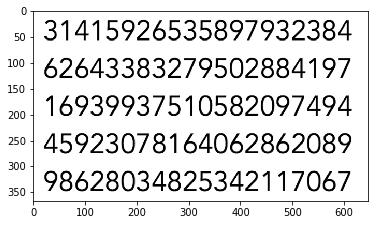

In [25]:
# 画像の読み込み
im = cv2.imread('numbers100.PNG')
plt.imshow(im)

In [57]:
# 輪郭を抽出
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # グレイスケールに
blur = cv2.GaussianBlur(gray, (5,5), 0) # ぼかす
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2) # 二値化
cv2.imwrite("numbers100-th.PNG", thresh)
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

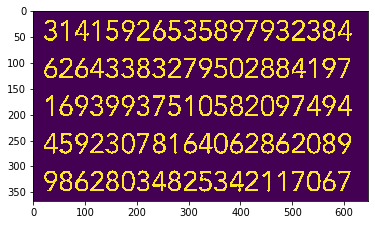

In [58]:
plt.imshow(thresh)

In [59]:
# 抽出した座標を左上から右下へと並べ替える
rects = []
im_w = im.shape[1]
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    if w < 10 or h < 10: # 小さすぎるのは飛ばす
        continue
    if w > im_w / 5: # 大きすぎるのも飛ばす
        continue
    y2 = round(y/10) * 10 # y座標を揃える
    index = y2 * im_w + x
    rects.append((index, x, y, w, h))
rects = sorted(rects, key=lambda x:x[0])

In [60]:
# 抽出した領域の画像データを得る
X = []
for i, r in enumerate(rects):
    index, x, y, w, h = r
    num = gray[y:y+h, x:x+w] # 部分画像を得る
    num = 255 - num # ネガポジ反転
    # 正方形の中に数字を描画
    ww = round((w if w > h else h) * 1.85)
    spc = np.zeros((ww, ww))
    wy = (ww - h) // 2
    wx = (ww - w) // 2
    spc[wy:wy+h, wx:wx+w] = num
    num = cv2.resize(spc, (28, 28)) # MNISTのサイズに揃える
    # cv2.imwrite(str(i)+"-num.PNG", num) " 切り出した様子を保存
    # データを正規化
    num = num.reshape(28*28)
    num = num.astype("float32") / 255
    X.append(num)

In [61]:
# 切り出した画像を予測
s = "31415926535897932384" + \
    "62643383279502884197" + \
    "16939937510582097494" + \
    "45923078164062862089" + \
    "98628034825342117067"
answer = list(s)
ok = 0
nlist = mnist.predict(np.array(X))
for i, n in enumerate(nlist):
    ans = n.argmax()
    if ans == int(answer[i]):
        ok += 1
    else:
        print("[ng]", i, "字目", ans, "!=", answer[i], np.int32(n*100))

print("正解率：", ok / len(nlist))

[ng] 37 字目 7 != 1 [ 0 27  0  4  0  0  0 42  0 22]
[ng] 40 字目 7 != 1 [ 0 26  0  3  1  0  0 45  0 23]
[ng] 49 字目 7 != 1 [ 0 34  0  1  1  0  0 39  0 21]
[ng] 67 字目 9 != 8 [ 6  0  4  1  0  4  0  9 33 37]
[ng] 68 字目 7 != 1 [ 0 17  0  4  0  0  0 51  0 24]
[ng] 74 字目 9 != 8 [ 2  0  1  1  0  2  0  5 14 72]
[ng] 78 字目 9 != 8 [ 2  0  1  1  0  2  0  5 18 66]
[ng] 94 字目 7 != 1 [ 0 29  0  2  0  0  0 55  0 12]
[ng] 95 字目 7 != 1 [ 0 24  0  2  1  0  0 45  0 26]
正解率： 0.91


## いろいろな数字フォントを学習させる

正解率が低い原因に同じフォントでしか学習をしておらず、手書き文字に対応できていないことが挙げられる。

In [91]:
import os, glob
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2, random
import matplotlib.pyplot as plt

In [92]:
# サイズの指定
image_size = 28 # MNISTと同じサイズ

In [93]:
# フォントの列挙
ttf_list = glob.glob("/Library/Fonts/*.ttf") # Mac
print("font count=", len(ttf_list))

font count= 1


In [94]:
# 中央に文字を描画
def draw_text(im, font, text):
    dr = ImageDraw.Draw(im)
    im_sz = np.array(im.size)
    fo_sz = np.array(font.getsize(text))
    xy = (im_sz - fo_sz) / 2
    # print(im_sz, fo_sz)
    dr.text(xy, text, font=font, fill=(255))

In [95]:
# サンプル画像を出力するフォルダ
if not os.path.exists("./image/num"):
    os.makedirs("./image/num")

In [96]:
# 回転させたり拡大したりしてデータを水増しする
def gen_image(base_im, no, font_name):
    for ang in range(-20, 20, 2):
        sub_im = base_im.rotate(ang)
        data = np.asarray(sub_im)
        X.append(data)
        Y.append(no)
        w = image_size
        # 少しずつ拡大する
        for r in range(8, 15, 3):
            size = round((r/10) * image_size)
            im2 = cv2.resize(data, (size, size), cv2.INTER_AREA)
            data2 = np.asarray(im2)
            if image_size > size: # sizeがimage_sizeより小さかったら0でパディング
                x = (image_size - size) // 2
                data = np.zeros((image_size, image_size))
                data[x:x+size, x:x+size] = data2
            else:
                x = (size - image_size) // 2
                data = data2[x:x+w, x:x+w]
            X.append(data)
            Y.append(no)
            if random.randint(0, 400) == 0:
                fname = "image/num/n-{0}-{1}-{2}.PNG".format(
                    font_name, no, ang, r)
                cv2.imwrite(fname, data)

In [97]:
# 画像に描画
X = []
Y = []
for path in ttf_list:
    font_name = os.path.basename(path)
    try:
        fo = ImageFont.truetype(path, size=100)
    except:
        continue
    for no in range(10):
        im = Image.new("L", (200, 200))
        draw_text(im, fo, str(no))
        # フォントの描画範囲を得る
        ima = np.asarray(im)
        blur = cv2.GaussianBlur(ima, (5,5), 0) # ぼかす
        th = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2) # 2値化
        contours = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w < 10 or h < 10:
                continue
            num = ima[y:y+h, x:x+w] # 部分画像を得る
            ww = w if w > h else h
            wx = (ww - w) // 2
            wy = (ww - h) // 2
            spc = np.zeros((ww, ww))
            spc[wy:wy+h, wx:wx+w] # 中央にコピー
            num = cv2.resize(spc, (image_size, image_size), cv2.INTER_AREA)
            # 標準の形状をデータに追加
            X.append(num)
            Y.append(no)
            # 少しずつ回転する
            base_im = Image.fromarray(np.uint8(num))
            gen_image(base_im, no, font_name)

In [98]:
X = np.array(X)
Y = np.array(Y)
np.savez("./image/font_draw.npz", x=X, y=Y)
print("ok", len(Y))

ok 810
